![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/visual-nlp/4.1.PDF_to_CHART_to_TEXT_LLM.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

For get the trial license please go to:

https://www.johnsnowlabs.com/install/

### Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.settings.enforce_versions=True
nlp.install(refresh_install=True, visual=True)

In [ ]:
import pkg_resources
import pandas as pd
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

In [ ]:
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_8542 (4).json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==5.3.1, 💊Spark-Healthcare==5.3.1, 🕶Spark-OCR==5.3.1, running on ⚡ PySpark==3.4.0


## Read images and display it

In [ ]:
from sparkocr.transformers import *
from sparkocr.enums import *


    Image #0:
    Origin: file:/content/test_chart.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3307 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


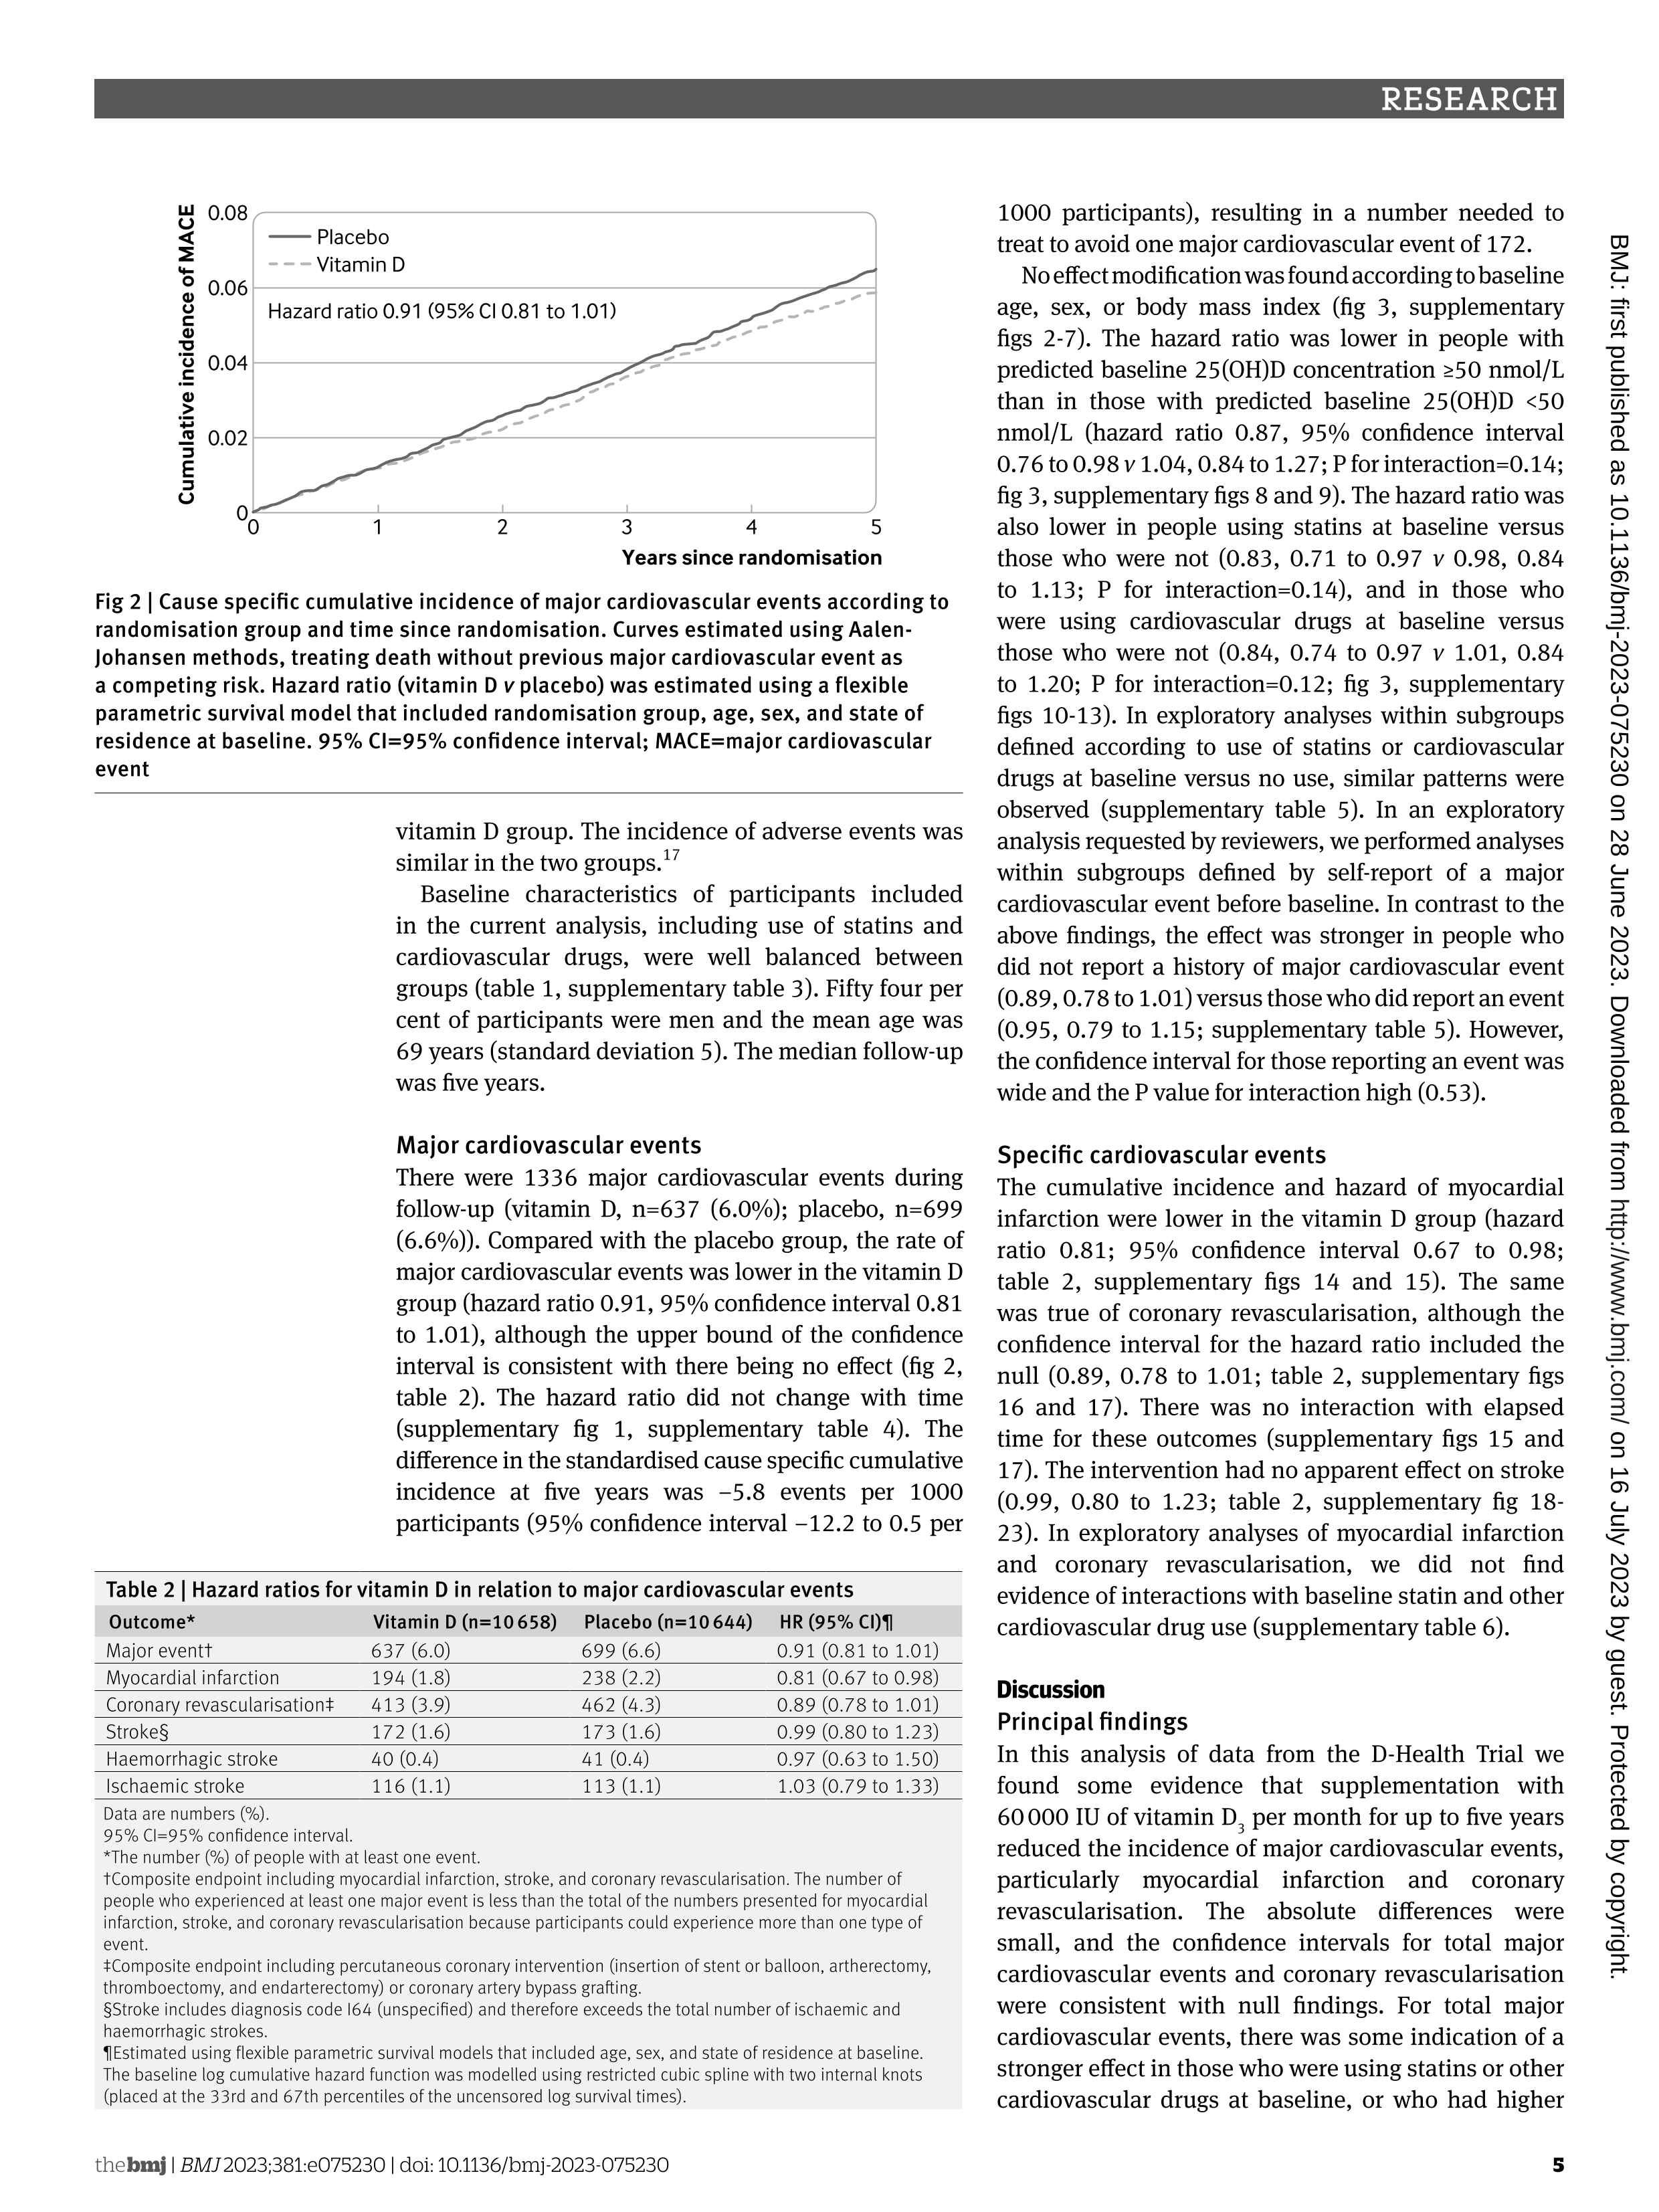

In [ ]:
pdf_path = "test_chart.pdf"
pdf_example_df = spark.read.format("binaryFile").load(pdf_path)
visual.display_pdf(pdf_example_df)

## Load Pipeline


In [ ]:
pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setKeepInput(True)

dit_layout = DocumentLayoutAnalyzer \
    .pretrained("publaynet_dit_base_mrcnn_jsl", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("regions") \
    .setScoreThreshold(0.6) \
    .setOutputLabels(["figure"])

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("regions") \
    .setOutputCol("image_with_regions") \
    .setRectColor(Color.green)

splitter = ImageSplitRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("regions") \
    .setOutputCol("figure_image") \
    .setDropCols("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

chart_to_text = ChartToTextTable() \
    .pretrained("chart_to_text_deplot_jsl", "en", "clinical/ocr") \
    .setInputCol(["figure_image"]) \
    .setOutputCol("answers") \
    .setUseCaching(False)

pipeline = PipelineModel(stages=[
    pdf_to_image,
    dit_layout,
    draw_regions,
    splitter,
    chart_to_text
])

publaynet_dit_base_mrcnn_jsl download started this may take some time.
Approximate size to download 401.2 MB
chart_to_text_deplot_jsl download started this may take some time.
Approximate size to download 999.7 MB


## Call the pipeline

In [ ]:
result = pipeline.transform(pdf_example_df).cache()


    Image #0:
    Origin: file:/content/test_chart.pdf
    Resolution: 0 dpi
    Width: 2480 px
    Height: 3307 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


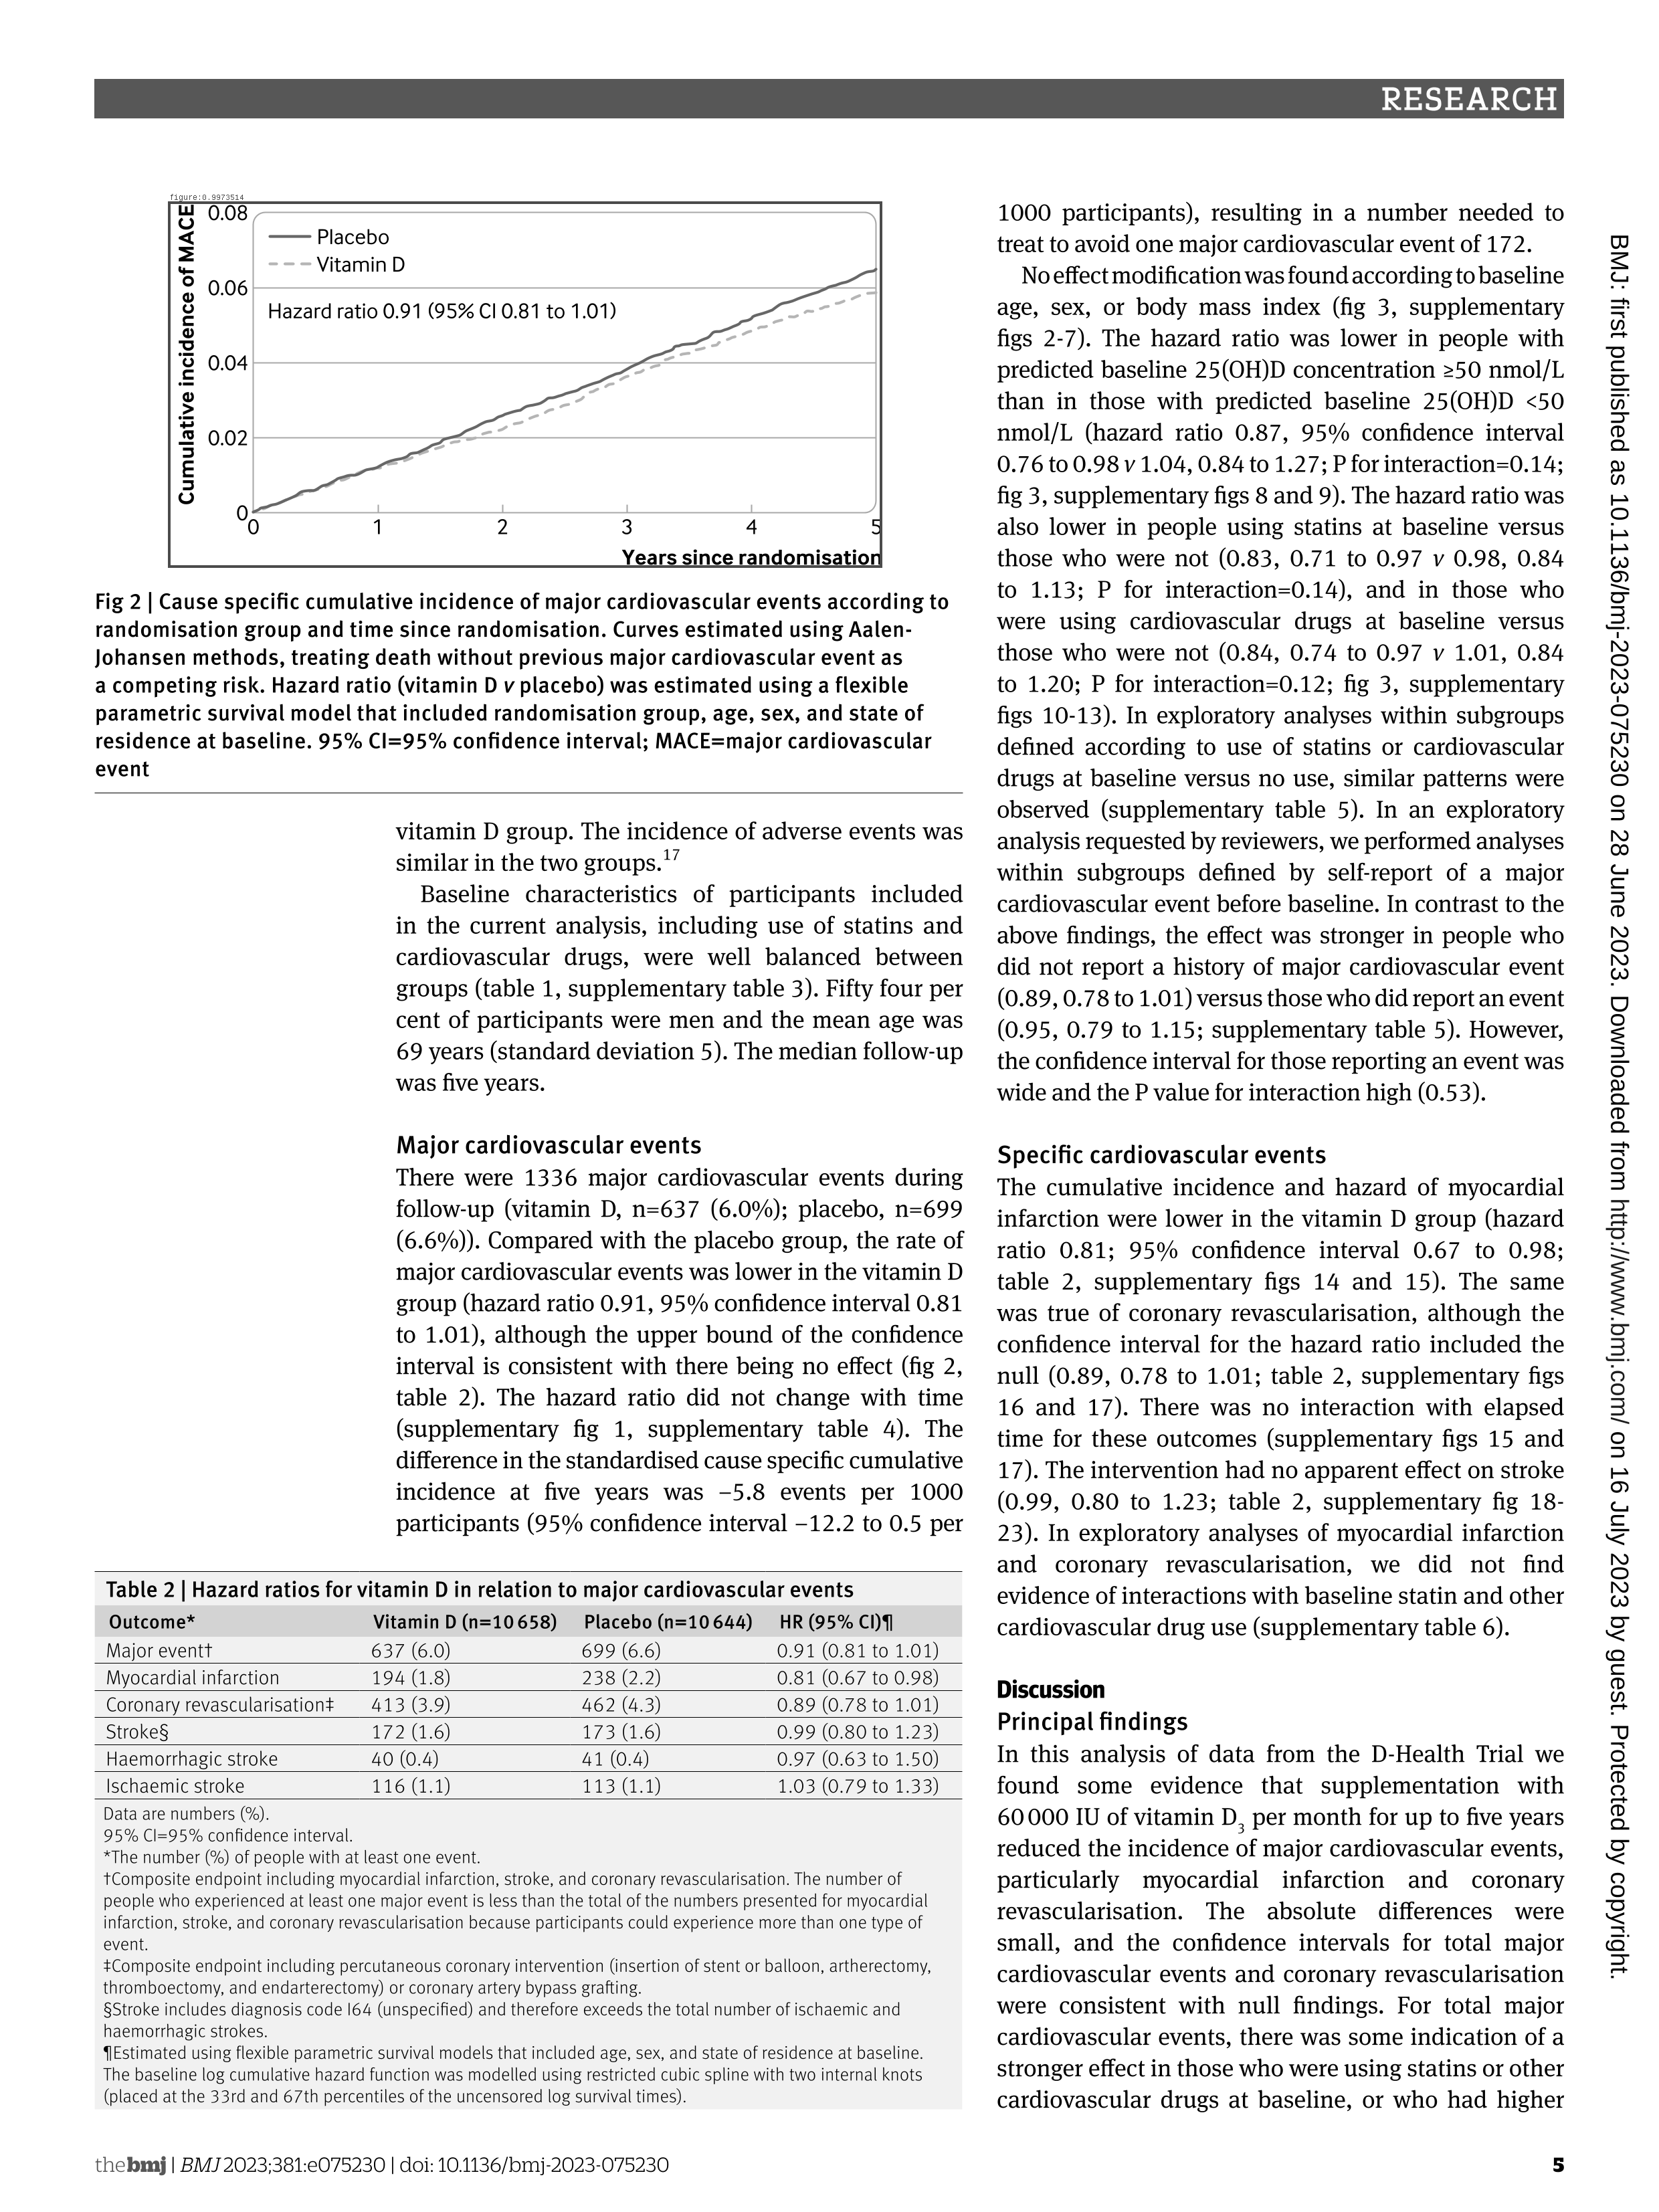

In [ ]:
visual.display_images(result, "image_with_regions")


    Image #0:
    Origin: file:/content/test_chart.pdf
    Resolution: 0 dpi
    Width: 1064 px
    Height: 544 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


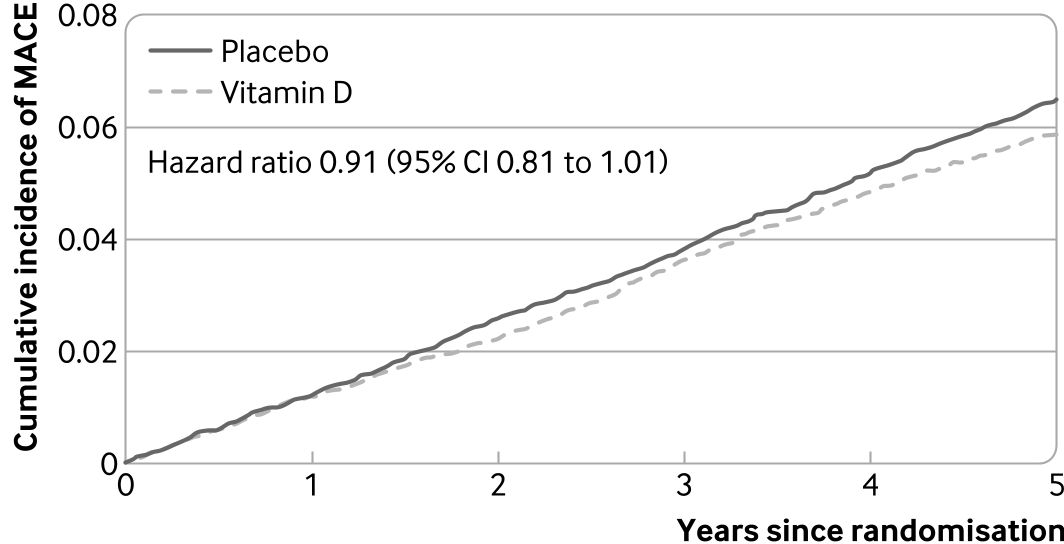

In [ ]:
visual.display_images(result, "figure_image")

In [ ]:
result = result.select(result.answers.answers).first()[0]

In [ ]:
chart = result[0]
chart

'  TITLE |  <0x0A> Years since randomisation | Placebo | Vitamin D<0x0A>2000 | 0.00 | 0.01<0x0A>2005 | 0.00 | 0.02<0x0A>2010 | 0.00 | 0.02<0x0A>2015 | 0.00 | 0.04<0x0A>2017 | 0.00 | 0.02<0x0A>2018 | 0.00 | 0.03<0x0A>2019 | 0.00 | 0.04<0x0A>2020 | 0.00 | 0.02<0x0A>2021 | 0.00 | 0.02<0x0A>2022 | 0.03 | 0.02<0x0A>2023 | 0.04 | 0'

## LLM part: explaining the Deplot chart results using LLAMA2-7B

In [ ]:
# GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama

model_name_or_path = "TheBloke/Llama-2-7B-chat-GGML"
model_basename = "llama-2-7b-chat.ggmlv3.q5_1.bin"

model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

llama-2-7b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/5.06G [00:00<?, ?B/s]

In [ ]:
# GPU params set
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,
    n_batch=3000,
    n_gpu_layers=32
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | VSX = 0 | 


In [ ]:
# See the number of layers in GPU
lcpp_llm.params.n_gpu_layers

32

In [ ]:
# Conversation template
prompt_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

USER: you are an expert in explaining charts. Can you please interpret as much as you can, the following information regarding a chart? "{chart}" (give me an answer please, this is not a conversation)

ASSISTANT:
'''

# Print the conversation template
print(prompt_template)


SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

USER: you are an expert in explaining charts. Can you please interpret as much as you can, the following information regarding a chart? "  TITLE |  <0x0A> Years since randomisation | Placebo | Vitamin D<0x0A>2000 | 0.00 | 0.01<0x0A>2005 | 0.00 | 0.02<0x0A>2010 | 0.00 | 0.02<0x0A>2015 | 0.00 | 0.04<0x0A>2017 | 0.00 | 0.02<0x0A>2018 | 0.00 | 0.03<0x0A>2019 | 0.00 | 0.04<0x0A>2020 | 0.00 | 0.02<0x0A>2021 | 0.00 | 0.02<0x0A>2022 | 0.03 | 0.02<0x0A>2023 | 0.04 | 0" (give me an answer please, this is not a conversation)

ASSISTANT:



In [ ]:
response=lcpp_llm(prompt=prompt_template, max_tokens=256, temperature=0.5, top_p=0.95,
                  repeat_penalty=1.2, top_k=150,
                  echo=True)

Llama.generate: prefix-match hit


In [ ]:
print(response)

{'id': 'cmpl-1f235507-48cb-406d-a21e-77eab9fad1d4', 'object': 'text_completion', 'created': 1713131741, 'model': '/root/.cache/huggingface/hub/models--TheBloke--Llama-2-7B-chat-GGML/snapshots/76cd63c351ae389e1d4b91cab2cf470aab11864b/llama-2-7b-chat.ggmlv3.q5_1.bin', 'choices': [{'text': 'SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.\n\nUSER: you are an expert in explaining charts. Can you please interpret as much as you can, the following information regarding a chart? "  TITLE |  <0x0A> Years since randomisation | Placebo | Vitamin D<0x0A>2000 | 0.00 | 0.01<0x0A>2005 | 0.00 | 0.02<0x0A>2010 | 0.00 | 0.02<0x0A>2015 | 0.00 | 0.04<0x0A>2017 | 0.00 | 0.02<0x0A>2018 | 0.00 | 0.03<0x0A>2019 | 0.00 | 0.04<0x0A>2020 | 0.00 | 0.02<0x0A>2021 | 0.00 | 0.02<0x0A>2022 | 0.03 | 0.02<0x0A>2023 | 0.04 | 0" (give me an answer please, this is not a conversation)\n\nASSISTANT:\nThe chart shows the number of years since randomization for patients in each group (

## LLAMA2 interpretation results

In [ ]:
output = response["choices"][0]["text"].split("ASSISTANT:")[1]
print (output)


The chart shows the number of years since randomization for patients in each group (Placebo and Vitamin D supplementation). The x-axis represents the years since randomization, while the y-axis represents the proportion of patients with 25(OH)D levels above a certain threshold (0.00, 0.01, 0.02, etc.).

Here are some key observations from the chart:

* The Placebo group has a consistent trend of having higher proportions of patients with 25(OH)D levels above the various thresholds compared to the Vitamin D supplementation group. Specifically, in 2000, 38% of Placebo patients had 25(OH)D levels above 0.01, while only 24%


In [ ]:
import textwrap
output = textwrap.fill(output, width=100)
print(output)

 The chart shows the number of years since randomization for patients in each group (Placebo and
Vitamin D supplementation). The x-axis represents the years since randomization, while the y-axis
represents the proportion of patients with 25(OH)D levels above a certain threshold (0.00, 0.01,
0.02, etc.).  Here are some key observations from the chart:  * The Placebo group has a consistent
trend of having higher proportions of patients with 25(OH)D levels above the various thresholds
compared to the Vitamin D supplementation group. Specifically, in 2000, 38% of Placebo patients had
25(OH)D levels above 0.01, while only 24%
